## Importing Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import geopandas as gp
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import folium
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## Importing Cleveland Neighborhood Geographical Information

#### Read in GeoJSON file

In [2]:
geography_data = gp.read_file("https://raw.githubusercontent.com/blackmad/neighborhoods/master/cleveland.geojson")

#### Determining Geographical Center of Each Neighborhood

In [3]:
# Add new columns for latitude and longitude of center point in each neighborhood
geography_data["latitude"] = geography_data.centroid.y
geography_data["longitude"] = geography_data.centroid.x

# Create
geography_data = geography_data[['name', 'latitude', 'longitude']].copy()

print(geography_data.head())

             name   latitude  longitude
0  Buckeye Shaker  41.481446 -81.594416
1       Glenville  41.532474 -81.618853
2        Downtown  41.507316 -81.685122
3    Euclid Green  41.551249 -81.552454
4          Cudell  41.472448 -81.756339


/Users/katelyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/Users/katelyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


## Importing Cleveland Neighborhood Housing Prices Data

In [4]:
housing_data = pd.read_csv('cleveland_housing.csv')

#### Prepare Housing Data By Calculating Mean Housing Price for 2020 and Dropping Unwanted Columns

In [5]:
# Set variable col to contain columns to calculate the yearly mean of housing prices for 2020
col = housing_data.loc[: , "1/31/20":"12/31/20"]

# Create new column with calculated mean using the parameter col
housing_data['housing_mean'] = col.mean(axis=1)

# Convert housing_mean values to Integers
housing_data['housing_mean'] = housing_data['housing_mean'].astype(int)

# Selecting only relevant columns of RegionName and housing_mean
housing_data = housing_data[['RegionName', 'housing_mean']]

# Rename RegionName column to name
housing_data = housing_data.rename(columns={"RegionName": "name"})

housing_data.head()


,name,housing_mean
0,Old Brooklyn,103011
1,Kamm's Corners,154741
2,Jefferson,92120
3,Puritas Longmead,82996
4,West Boulevard,77171


#### Check That Neighborhood Names Are Contained In Geographical Data

In [6]:
housing_data['name'].isin(geography_data['name'])

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
Name: name, dtype: bool

In [7]:
neighborhoods = housing_data.merge(geography_data, on='name', how='left')
neighborhoods = neighborhoods.rename(columns={"name": "Neighborhood"})

In [8]:
neighborhoods.head()

,Neighborhood,housing_mean,latitude,longitude
0,Old Brooklyn,103011,41.433555,-81.704266
1,Kamm's Corners,154741,41.452543,-81.814195
2,Jefferson,92120,41.452883,-81.786845
3,Puritas Longmead,82996,41.430653,-81.792927
4,West Boulevard,77171,41.459105,-81.755003


## Gather Venue Data From FourSquare

#### Define FourSquare Credentials

In [9]:
CLIENT_ID = 'VLGDWASSNNSWZYS3GCP3BPYT4JNXXYOR4G44I0QRWPMW5VZ4'
CLIENT_SECRET = 'V2EWODEVPWH1YPI2LMQXJDQDYR2P0AQSMJS4VNH2C1WJFZAD'
VERSION = '20180605'

#### Define URL Building Function

In [10]:
def getBuiltUrl(neigh_lat,neigh_long,radius=2000):
    LIMIT=100
    #radius=1000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_lat, 
    neigh_long, 
    radius, 
    LIMIT)
    return url

#### Explore First Neighborhood in Data Frame

In [11]:

neigh_name, neigh_price, neigh_lat, neigh_long = neighborhoods.iloc[0]
print('Latitude and longitude values of {} are {}, {}.'.format(neigh_name, 
                                                               neigh_lat, 
                                                               neigh_long))
results = requests.get(getBuiltUrl(neigh_lat,neigh_long)).json()
results

Latitude and longitude values of Old Brooklyn are 41.43355540904634, -81.70426594563327.


{'meta': {'code': 200, 'requestId': '6098226b78239367b545fbca'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Old Brooklyn',
  'headerFullLocation': 'Old Brooklyn, Cleveland',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 116,
  'suggestedBounds': {'ne': {'lat': 41.45155542704636,
    'lng': -81.68030190222233},
   'sw': {'lat': 41.415555391046325, 'lng': -81.72822998904421}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ba181c6f964a520aebc37e3',
       'name': 'Honey Hut Ice Cream Shoppe',
       'location': {'address': '4674 State Rd',
        'crossStreet': 'at Buechner Ave',
        'lat': 41.427268803202246,
   

In [12]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [13]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Honey Hut Ice Cream Shoppe,Ice Cream Shop,41.427269,-81.709299
1,Gus's Family Restaurant,American Restaurant,41.435241,-81.706799
2,Gabe's Family Restaurant,Diner,41.436033,-81.697852
3,Gyro Guys,Deli / Bodega,41.437305,-81.708551
4,All Seasons Tanning,Tanning Salon,41.439055,-81.701357


In [14]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


#### Explore All Neighborhoods in Cleveland

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000, limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
cleveland_venues = getNearbyVenues(names=neighborhoods['Neighborhood'], 
                                   latitudes=neighborhoods['latitude'], 
                                   longitudes=neighborhoods['longitude'])

Old Brooklyn
Kamm's Corners
Jefferson
Puritas Longmead
West Boulevard
South Broadway
Mt Pleasant
Glenville
North Collinwood
Lee Miles
Detroit Shoreway
Hough
Central
Corlett
Buckeye Shaker
South Collinwood
Clark Fulton
Cudell
Union Miles Park
Ohio City
Downtown
Brooklyn Centre
University
Edgewater
Woodland Hills
Stockyards
Tremont
Saint Clair-Superior
North Broadway
Euclid Green
Fairfax
Goodrich-Kirtland Park
Kinsman
Riverside


In [17]:
cleveland_venues.shape

(2057, 7)

In [18]:
cleveland_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Old Brooklyn,41.433555,-81.704266,Honey Hut Ice Cream Shoppe,41.427269,-81.709299,Ice Cream Shop
1,Old Brooklyn,41.433555,-81.704266,Gus's Family Restaurant,41.435241,-81.706799,American Restaurant
2,Old Brooklyn,41.433555,-81.704266,Gabe's Family Restaurant,41.436033,-81.697852,Diner
3,Old Brooklyn,41.433555,-81.704266,Gyro Guys,41.437305,-81.708551,Deli / Bodega
4,Old Brooklyn,41.433555,-81.704266,All Seasons Tanning,41.439055,-81.701357,Tanning Salon


In [19]:
cleveland_venue_counts = cleveland_venues.groupby('Neighborhood').size().reset_index(name='Venues')

In [20]:
cleveland_counts_housing = cleveland_venue_counts.merge(neighborhoods, on='Neighborhood')

In [21]:
cleveland_counts_housing_sorted = cleveland_counts_housing.sort_values('Venues')

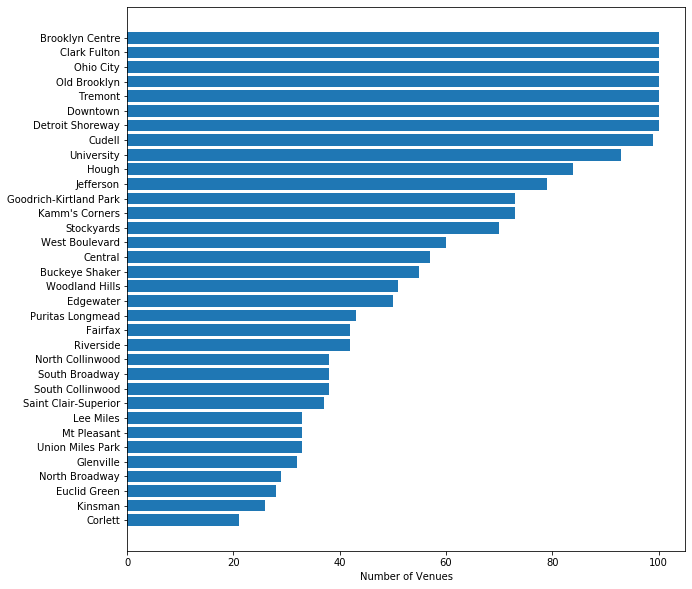

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

ax.barh(cleveland_counts_housing_sorted['Neighborhood'], cleveland_counts_housing_sorted['Venues'], align='center')
ax.set_xlabel('Number of Venues')

plt.show()

Text(0, 0.5, 'Housing Price')

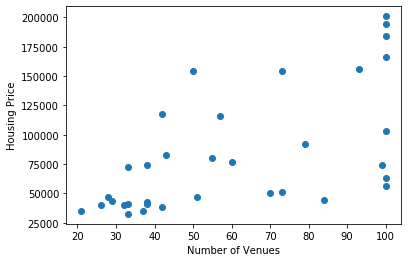

In [23]:
plt.scatter(cleveland_counts_housing['Venues'], cleveland_counts_housing['housing_mean'])

plt.xlabel('Number of Venues')
plt.ylabel('Housing Price')

In [24]:
print('There are {} uniques categories.'.format(len(cleveland_venues['Venue Category'].unique())))

There are 235 uniques categories.


## Analyze Each Neighborhood

In [25]:
# one hot encoding
cleveland_onehot = pd.get_dummies(cleveland_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cleveland_onehot['Neighborhood'] = cleveland_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [cleveland_onehot.columns[-1]] + list(cleveland_onehot.columns[:-1])
cleveland_onehot = cleveland_onehot[fixed_columns]

cleveland_onehot.head()

,Neighborhood,ATM,Adult Boutique,Airport,Airport Lounge,Airport Service,American Restaurant,Amphitheater,Antique Shop,Arcade,...,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Old Brooklyn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Old Brooklyn,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Old Brooklyn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Old Brooklyn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Old Brooklyn,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
cleveland_onehot.shape

(2057, 236)

In [27]:
cleveland_grouped = cleveland_onehot.groupby('Neighborhood').mean().reset_index()
cleveland_grouped.shape

(34, 236)

In [28]:
num_top_venues = 5

for hood in cleveland_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = cleveland_grouped[cleveland_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Brooklyn Centre----
            venue  freq
0     Zoo Exhibit  0.16
1  Sandwich Place  0.07
2     Pizza Place  0.04
3        Pharmacy  0.04
4           Diner  0.03


----Buckeye Shaker----
                 venue  freq
0   Light Rail Station  0.09
1       Discount Store  0.05
2                 Bank  0.05
3  American Restaurant  0.05
4       Farmers Market  0.04


----Central----
                  venue  freq
0    Chinese Restaurant  0.05
1        Sandwich Place  0.05
2         Grocery Store  0.05
3  Fast Food Restaurant  0.05
4                Bakery  0.04


----Clark Fulton----
            venue  freq
0     Zoo Exhibit  0.12
1  Sandwich Place  0.08
2           Diner  0.04
3   Grocery Store  0.03
4     Gas Station  0.03


----Corlett----
                  venue  freq
0        Discount Store  0.14
1  Fast Food Restaurant  0.10
2         Grocery Store  0.10
3           Gas Station  0.10
4            Restaurant  0.05


----Cudell----
                venue  freq
0         Pizza Place  0.

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = cleveland_grouped['Neighborhood']

for ind in np.arange(cleveland_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cleveland_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Brooklyn Centre,Zoo Exhibit,Sandwich Place,Pharmacy,Pizza Place,Coffee Shop,Diner,Discount Store,Bar,Fried Chicken Joint,Cosmetics Shop
1,Buckeye Shaker,Light Rail Station,Discount Store,Bank,American Restaurant,Park,Skating Rink,Fast Food Restaurant,Farmers Market,Sandwich Place,Diner
2,Central,Chinese Restaurant,Grocery Store,Fast Food Restaurant,Sandwich Place,Convenience Store,Bakery,Gas Station,Imported Food Shop,Fried Chicken Joint,Discount Store
3,Clark Fulton,Zoo Exhibit,Sandwich Place,Diner,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Dive Bar,Department Store,Pharmacy,Grocery Store
4,Corlett,Discount Store,Fast Food Restaurant,Gas Station,Grocery Store,Bank,Sandwich Place,Liquor Store,Restaurant,Seafood Restaurant,Thrift / Vintage Store


## Cluster Neighborhoods

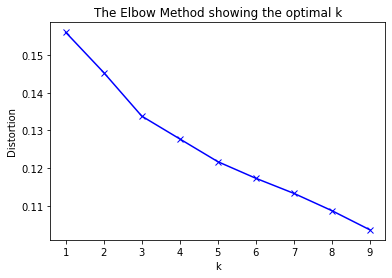

In [31]:
cleveland_grouped_clustering = cleveland_grouped.drop('Neighborhood', 1)

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(cleveland_grouped_clustering)
    kmeanModel.fit(cleveland_grouped_clustering)
    distortions.append(sum(np.min(cdist(cleveland_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / cleveland_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [32]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cleveland_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [33]:
cleveland_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
cleveland_merged = cleveland_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

cleveland_merged.head() # check the last columns!

,Neighborhood,housing_mean,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Old Brooklyn,103011,41.433555,-81.704266,2,Zoo Exhibit,Bar,Convenience Store,Pharmacy,Discount Store,Diner,Pizza Place,Sandwich Place,Fast Food Restaurant,Chinese Restaurant
1,Kamm's Corners,154741,41.452543,-81.814195,0,Video Store,Gym / Fitness Center,American Restaurant,Bar,New American Restaurant,Convenience Store,Sandwich Place,Salon / Barbershop,Café,Pharmacy
2,Jefferson,92120,41.452883,-81.786845,1,Sandwich Place,Discount Store,Grocery Store,Pizza Place,Fast Food Restaurant,Pharmacy,Gas Station,Video Store,Park,Dive Bar
3,Puritas Longmead,82996,41.430653,-81.792927,1,Discount Store,Diner,Sandwich Place,Gas Station,Pizza Place,Gym,Hotel,Pharmacy,Grocery Store,Bowling Alley
4,West Boulevard,77171,41.459105,-81.755003,1,Discount Store,Pizza Place,Gas Station,Grocery Store,Pharmacy,Sandwich Place,Department Store,Picnic Area,Deli / Bodega,Mexican Restaurant


## Examine Neighborhood Clusters

Cluster 1 appears to largely contain Resaurants and Culture

In [34]:
cleveland_merged[cleveland_merged['Cluster Labels'] == 0]

,Neighborhood,housing_mean,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Kamm's Corners,154741,41.452543,-81.814195,0,Video Store,Gym / Fitness Center,American Restaurant,Bar,New American Restaurant,Convenience Store,Sandwich Place,Salon / Barbershop,Café,Pharmacy
8,North Collinwood,74247,41.576722,-81.564320,0,Bar,Park,Gas Station,Sandwich Place,Restaurant,Pizza Place,Record Shop,Fried Chicken Joint,Music Venue,Bank
10,Detroit Shoreway,166485,41.480153,-81.729880,0,Bar,Art Gallery,Beach,Food Truck,Coffee Shop,Diner,Sandwich Place,Mexican Restaurant,Theater,Seafood Restaurant
17,Cudell,74281,41.472448,-81.756339,0,Pizza Place,Grocery Store,Pharmacy,Gay Bar,Convenience Store,Sandwich Place,Deli / Bodega,Mexican Restaurant,Diner,Art Gallery
19,Ohio City,201028,41.485930,-81.710440,0,Bar,Brewery,Coffee Shop,Gastropub,Park,Gym / Fitness Center,American Restaurant,Market,Italian Restaurant,Pizza Place
20,Downtown,184126,41.507316,-81.685122,0,Hotel,Coffee Shop,American Restaurant,Theater,Steakhouse,Deli / Bodega,Brewery,Burger Joint,Café,Park
22,University,155712,41.505742,-81.605450,0,Italian Restaurant,Coffee Shop,Hotel,Bakery,Pizza Place,Grocery Store,History Museum,Sandwich Place,Gym / Fitness Center,Café
23,Edgewater,154639,41.484058,-81.758973,0,Diner,Cocktail Bar,Sandwich Place,Park,Grocery Store,Seafood Restaurant,Bar,Food & Drink Shop,Dive Bar,Pub
26,Tremont,194001,41.473853,-81.686507,0,Pub,Sandwich Place,Bar,Coffee Shop,Brewery,Bakery,Pizza Place,Cocktail Bar,Pet Store,Park
30,Fairfax,38799,41.495948,-81.627443,0,Hotel,Bakery,Grocery Store,Pharmacy,Concert Hall,Coffee Shop,Café,Sandwich Place,History Museum,Light Rail Station


Cluster 2 appears to largely contain Discount Stores and Fast Food

In [35]:
cleveland_merged[cleveland_merged['Cluster Labels'] == 1]

,Neighborhood,housing_mean,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Jefferson,92120,41.452883,-81.786845,1,Sandwich Place,Discount Store,Grocery Store,Pizza Place,Fast Food Restaurant,Pharmacy,Gas Station,Video Store,Park,Dive Bar
3,Puritas Longmead,82996,41.430653,-81.792927,1,Discount Store,Diner,Sandwich Place,Gas Station,Pizza Place,Gym,Hotel,Pharmacy,Grocery Store,Bowling Alley
4,West Boulevard,77171,41.459105,-81.755003,1,Discount Store,Pizza Place,Gas Station,Grocery Store,Pharmacy,Sandwich Place,Department Store,Picnic Area,Deli / Bodega,Mexican Restaurant
5,South Broadway,40592,41.452492,-81.646462,1,Sandwich Place,Discount Store,Grocery Store,Fast Food Restaurant,Pharmacy,Dive Bar,Pizza Place,Chinese Restaurant,Park,Bank
6,Mt Pleasant,41143,41.463187,-81.589845,1,Pharmacy,Discount Store,Grocery Store,Light Rail Station,Convenience Store,Park,Food & Drink Shop,Restaurant,Bank,Fried Chicken Joint
7,Glenville,39959,41.532474,-81.618853,1,Fast Food Restaurant,BBQ Joint,Convenience Store,Park,Discount Store,Grocery Store,Boutique,Bank,Fried Chicken Joint,Football Stadium
9,Lee Miles,72477,41.442246,-81.562735,1,Fast Food Restaurant,Discount Store,BBQ Joint,Gas Station,Seafood Restaurant,Bank,Market,Southern / Soul Food Restaurant,Mobile Phone Shop,Donut Shop
11,Hough,44827,41.511836,-81.632282,1,Hotel,Bus Stop,Discount Store,Grocery Store,Sandwich Place,Pharmacy,Garden,Flea Market,Park,Coffee Shop
12,Central,115980,41.493980,-81.655294,1,Chinese Restaurant,Grocery Store,Fast Food Restaurant,Sandwich Place,Convenience Store,Bakery,Gas Station,Imported Food Shop,Fried Chicken Joint,Discount Store
13,Corlett,34737,41.448268,-81.589089,1,Discount Store,Fast Food Restaurant,Gas Station,Grocery Store,Bank,Sandwich Place,Liquor Store,Restaurant,Seafood Restaurant,Thrift / Vintage Store


Cluster 3 appears to largely contain Delis and Convenience Stores

In [36]:
cleveland_merged[cleveland_merged['Cluster Labels'] == 2]

,Neighborhood,housing_mean,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Old Brooklyn,103011,41.433555,-81.704266,2,Zoo Exhibit,Bar,Convenience Store,Pharmacy,Discount Store,Diner,Pizza Place,Sandwich Place,Fast Food Restaurant,Chinese Restaurant
16,Clark Fulton,56220,41.463211,-81.710066,2,Zoo Exhibit,Sandwich Place,Diner,Gas Station,Fried Chicken Joint,Fast Food Restaurant,Dive Bar,Department Store,Pharmacy,Grocery Store
21,Brooklyn Centre,62837,41.452741,-81.700421,2,Zoo Exhibit,Sandwich Place,Pharmacy,Pizza Place,Coffee Shop,Diner,Discount Store,Bar,Fried Chicken Joint,Cosmetics Shop
25,Stockyards,50576,41.458439,-81.730068,2,Zoo Exhibit,Pizza Place,Dive Bar,Discount Store,Deli / Bodega,Sandwich Place,Bar,Ice Cream Shop,Intersection,Fast Food Restaurant


In [37]:
di = {0: 'Restaurants and Culture', 1: 'Discount Stores and Fast Food', 2: 'Delis and Convenience Stores'}

In [38]:
cleveland_merged['Cluster Name'] = cleveland_merged['Cluster Labels'].map(di)

In [39]:
cleveland_data = cleveland_merged[['Neighborhood', 'housing_mean', 'latitude', 'longitude', 'Cluster Labels', 'Cluster Name']]

In [40]:
cleveland_data.head()

,Neighborhood,housing_mean,latitude,longitude,Cluster Labels,Cluster Name
0,Old Brooklyn,103011,41.433555,-81.704266,2,Delis and Convenience Stores
1,Kamm's Corners,154741,41.452543,-81.814195,0,Restaurants and Culture
2,Jefferson,92120,41.452883,-81.786845,1,Discount Stores and Fast Food
3,Puritas Longmead,82996,41.430653,-81.792927,1,Discount Stores and Fast Food
4,West Boulevard,77171,41.459105,-81.755003,1,Discount Stores and Fast Food


## Create Bins For Housing Values

#### Visualize Distribution of Housing Prices

Text(0.5, 1.0, 'Price bins')

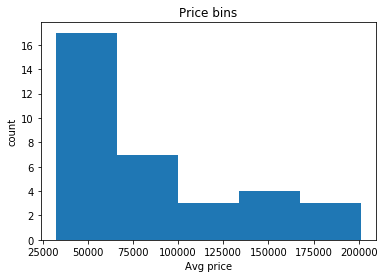

In [41]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(cleveland_data["housing_mean"],bins=5)

# set x/y labels and plot title
plt.pyplot.xlabel("Avg price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price bins")

#### Create an Array of Boundaries for Housing Price Bins

In [42]:
bins = np.linspace(min(cleveland_data["housing_mean"]), max(cleveland_data["housing_mean"]), 6)
bins

array([ 32558.,  66252.,  99946., 133640., 167334., 201028.])

#### Name Each Bin

In [43]:
group_names = ['Low level 1', 
               'Low level 2', 
               'Average level', 
               'High level 1',
               'High level 2']

#### Add Housing Price Categories Columns to Dataframe

In [44]:
cleveland_data['Price-Categories'] = pd.cut(cleveland_data['housing_mean'], bins, labels=group_names, include_lowest=True )
cleveland_data.head()

/Users/katelyn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,housing_mean,latitude,longitude,Cluster Labels,Cluster Name,Price-Categories
0,Old Brooklyn,103011,41.433555,-81.704266,2,Delis and Convenience Stores,Average level
1,Kamm's Corners,154741,41.452543,-81.814195,0,Restaurants and Culture,High level 1
2,Jefferson,92120,41.452883,-81.786845,1,Discount Stores and Fast Food,Low level 2
3,Puritas Longmead,82996,41.430653,-81.792927,1,Discount Stores and Fast Food,Low level 2
4,West Boulevard,77171,41.459105,-81.755003,1,Discount Stores and Fast Food,Low level 2


## Map Results

#### Obtain Geographical Coordinates for Cleveland, OH

In [45]:
address = 'Cleveland, OH'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Cleveland are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Cleveland are 41.5051613, -81.6934446.


#### Map Venue Clusters

In [46]:

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, clustername, clusterlabel in zip(cleveland_data['latitude'], cleveland_data['longitude'], cleveland_data['Neighborhood'], cleveland_data['Cluster Name'], cleveland_data['Cluster Labels']):
    label = folium.Popup('Neighborhood: {} | Cluster: {}'.format(poi, clustername))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[clusterlabel-1],
        fill=True,
        fill_color=rainbow[clusterlabel-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Add Neighborhood Values to Cluster Map

In [47]:
lnd_geo = r"https://raw.githubusercontent.com/blackmad/neighborhoods/master/cleveland.geojson"
lnd_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

lnd_map.choropleth(
    geo_data=lnd_geo,
    data=cleveland_merged,
    columns=['Neighborhood','housing_mean'],
    key_on='feature.properties.name',
    fill_color='RdPu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average house Prices'
)
# add markers to the map
markers_colors = []
for lat, lon, poi, clustername, clusterlabel in zip(cleveland_data['latitude'], cleveland_data['longitude'], cleveland_data['Neighborhood'], cleveland_data['Cluster Name'], cleveland_data['Cluster Labels']):
    label = folium.Popup('Neighborhood: {} | Cluster: {}'.format(poi, clustername))
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[clusterlabel-1],
        fill=True,
        fill_color=rainbow[clusterlabel-1],
        fill_opacity=0.7).add_to(lnd_map)
       
# display map
lnd_map

/Users/katelyn/opt/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
